# Testing Chessboard Image Warping

This aims to test warping using tensorflow and compare it to Scipy interpolation on affine transformations.

## Declarations

In [72]:
# fix python imports relative paths issues
%cd ../../

e:\System Folders


In [73]:
# auto reload imports if they been modified

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
# limit TF GPU memory usage

from source.framework.tools.gpu_tools import config_gpu

config_gpu(gpu_index=None, memory_limit_gb=3)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [75]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

from ipywidgets import interact, widgets

from scipy.ndimage import affine_transform

In [76]:
from source.framework.settings.whole_config import WholeConfig
from source.framework.settings.synthetic_fields_provider import SyntheticFieldsProvider

from source.framework.tools.gradient_chessboard_generator import (
    random_gradient_chessboard,
)
from source.framework.tools.plotting_helper import vector_field_drawer, heat_map_drawer
from source.framework.tools.affine_random_fields import (
    image_affine_matrix_2d,
    image_affine_matrix_3d,
    random_image_affine_matrix,
    flow_fields_from_batch_affine_matrices,
)

from source.model.tools.operators.sampling_operator import sample
from source.model.tools.operators.warping_operator import warp_images

In [77]:
config = WholeConfig("delete")

## Help functions

In [78]:
def plot_img(img, title="") -> None:
    heat_map_drawer(
        img,
        title=title,
        display_grid=False,
        display_axis=False,
        title_font_size=None,
        color_map_name=config.images_preview_color_map,
        color_map_min_val=0,
        color_map_max_val=255,
    )
    plt.show()

In [79]:
def array_to_tensor(array):
    tensor = tf.convert_to_tensor(array, dtype=config.float_data_type)
    tensor = tf.expand_dims(tensor, axis=0)
    return tensor


def tensor_to_array(tensor):
    return tensor[0, ...].numpy()

In [80]:
def max_vector_field_norm(x, y):
    return np.sqrt(np.max(np.abs(x)) ** 2 + np.max(np.abs(y)) ** 2) * 2


def draw_vector_field(x, y):
    vector_field_drawer(
        x,
        y,
        title="Displacement Vector Filed",
        display_grid=False,
        display_axis=False,
        title_font_size=None,
        color_map_name=config.vector_fields_images_preview_color_map,
        max_length=max_vector_field_norm(x, y),
    )


def draw_displacement_field(flow_field_tensor):
    # we need to convert dense to sparse field for easy of visualization
    displacement_field_tensor = sample(
        flow_field_tensor, config.displacements_control_points_spacings
    )
    displacement_field_tensor = tensor_to_array(displacement_field_tensor)

    X = displacement_field_tensor[..., 0]
    Y = displacement_field_tensor[..., 1]

    draw_vector_field(X, Y)
    plt.show()

## 2D

### Help Functions

In [81]:
def apply_affine_matrix_my(inv_matrix, img):
    image_core_size = list(img.shape[0:2])

    inv_trans_tensor = array_to_tensor(inv_matrix)

    flow_field = flow_fields_from_batch_affine_matrices(
        inv_trans_tensor, image_core_size, config.float_data_type
    )

    draw_displacement_field(flow_field)

    img_tensor = array_to_tensor(img)
    img_output_tensor, transformation_grid = warp_images(img_tensor, flow_field)

    img_output_array = tensor_to_array(img_output_tensor)

    plot_img(img_output_array[:, :, 0], "My Trans")

    print("flow filed")
    print(flow_field[0, ..., 0])
    print(flow_field[0, ..., 1])

    print("\n========\n")

    print("Sampling points")
    print(transformation_grid[0, :, :, 0])
    print(transformation_grid[0, :, :, 1])

    # trans_fields_tensor_interpolated = sample(trans_fields_tensor, configdisplacements_control_points_spacings)
    # resizer = ResizingOperator(2, ResizingMethods.B_SPLINES)
    # trans_fields_tensor_interpolated = resizer.make_like(trans_fields_tensor_interpolated, trans_fields_tensor)

    # print(trans_fields_tensor_interpolated[0,...,0])
    # print(trans_fields_tensor_interpolated[0,...,1])

    # img_tensor = array_to_tensor(img)
    # trans_img_tensor = warp_images(img_tensor, trans_fields_tensor_interpolated)

    # trans_img_array = tensor_to_array(trans_img_tensor)
    # plot_img(trans_img_array)

    return img_output_array[:, :, 0]

In [82]:
def apply_affine_matrix_scipy(matrix, img):
    # Scipy assumes y-x coordinates in the matrix, so we need to switch from x-y.
    # but doing this for the affine matrix is not straight forward, so instead we
    # transpose the image and then apply the matrix, then transpose back

    img = np.transpose(img, (1, 0, 2))

    transformed_image = affine_transform(
        input=img[:, :, 0], matrix=matrix, mode="nearest", order=1, prefilter=False
    )

    transformed_image = np.transpose(transformed_image, (1, 0))

    plot_img(transformed_image, "SciPy Trans")

    return transformed_image

In [83]:
def compare_results(matrix, img):
    inv_matrix = np.linalg.inv(matrix)

    print("Affine matrix:\n", matrix)
    print("\nInverse affine matrix:\n", inv_matrix)

    plot_img(img, "Original")

    trans_img_my = apply_affine_matrix_my(inv_matrix, img)

    trans_img_scipy = apply_affine_matrix_scipy(inv_matrix, img)

    diff = trans_img_scipy - trans_img_my
    dif_max = np.max(np.abs(diff))

    if dif_max < 2.55:
        plot_img(
            np.clip(diff * 100, 0, 255), "x100 Diff"
        )  # we magnify differences to detect any
    else:
        plot_img(diff, "Diff")

    print(f"Max diff: {dif_max}")

### Generate Image

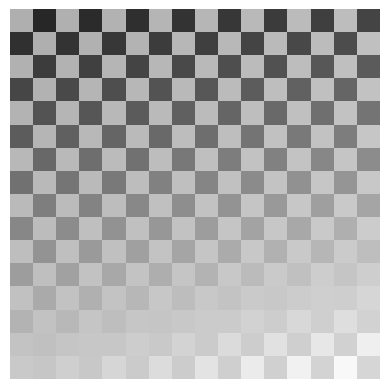

In [84]:
cell_size = 4
image_size_2d = 64
rank = 2

img = random_gradient_chessboard(
    output_size=[image_size_2d] * rank,
    random_cells_size_range=(cell_size, cell_size + 1),
    channels_count=1,
)

plot_img(img)

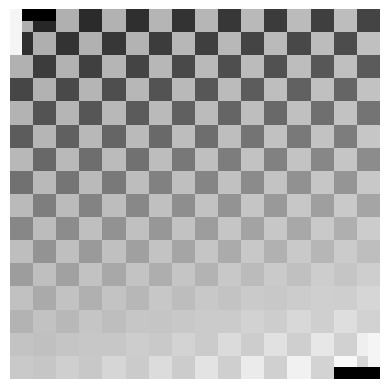

In [85]:
# mark corners to make it easier to spot any mirroring

marked_img = img.copy()

marked_img[0:2, 0:8] = 0
marked_img[0:8, 0:2] = 245

marked_img[56:64, 62:64] = 245
marked_img[62:64, 56:64] = 0

plot_img(marked_img)

### Translation

Affine matrix:
 [[1. 0. 2.]
 [0. 1. 0.]
 [0. 0. 1.]]

Inverse affine matrix:
 [[ 1.  0. -2.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


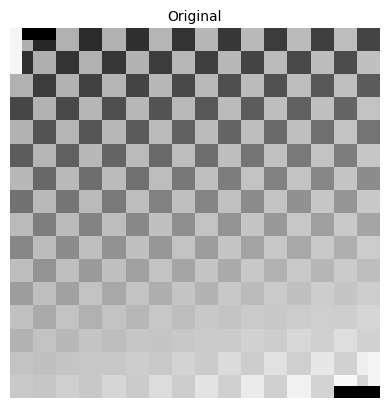

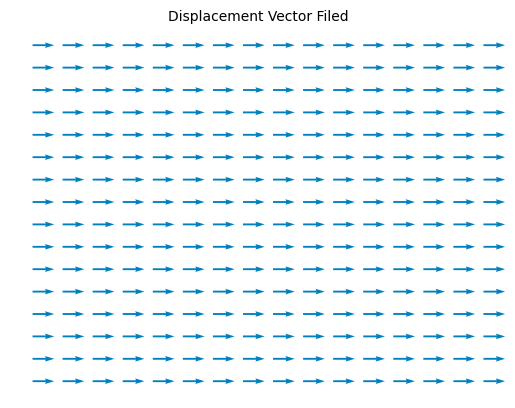

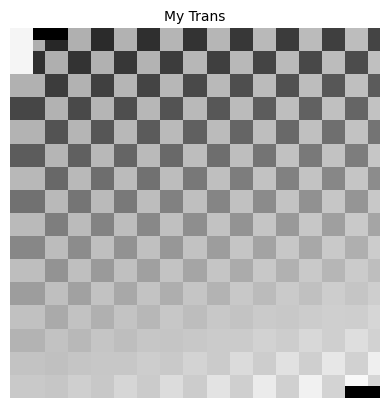

flow filed
tf.Tensor(
[[-2. -2. -2. ... -2. -2. -2.]
 [-2. -2. -2. ... -2. -2. -2.]
 [-2. -2. -2. ... -2. -2. -2.]
 ...
 [-2. -2. -2. ... -2. -2. -2.]
 [-2. -2. -2. ... -2. -2. -2.]
 [-2. -2. -2. ... -2. -2. -2.]], shape=(64, 64), dtype=float32)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(64, 64), dtype=float32)


Sampling points
tf.Tensor(
[[-2. -1.  0. ... 59. 60. 61.]
 [-2. -1.  0. ... 59. 60. 61.]
 [-2. -1.  0. ... 59. 60. 61.]
 ...
 [-2. -1.  0. ... 59. 60. 61.]
 [-2. -1.  0. ... 59. 60. 61.]
 [-2. -1.  0. ... 59. 60. 61.]], shape=(64, 64), dtype=float32)
tf.Tensor(
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 2.  2.  2. ...  2.  2.  2.]
 ...
 [61. 61. 61. ... 61. 61. 61.]
 [62. 62. 62. ... 62. 62. 62.]
 [63. 63. 63. ... 63. 63. 63.]], shape=(64, 64), dtype=float32)


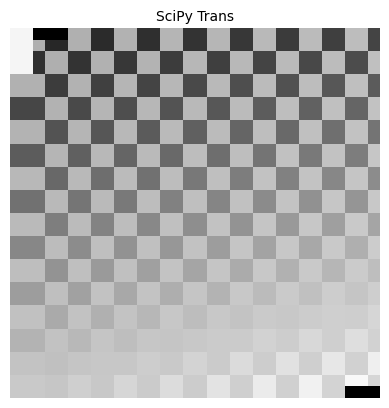

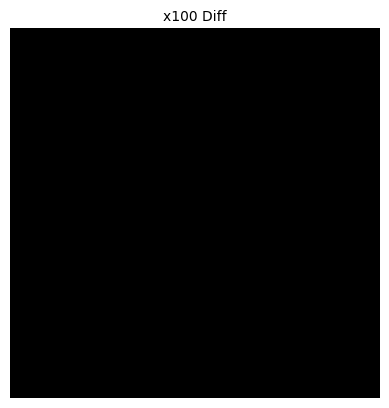

Max diff: 0.0


In [86]:
# x-direction
affine_matrix = image_affine_matrix_2d(
    image_size=(image_size_2d, image_size_2d),
    translation=(2, 0),
    scale=(1.0, 1.0),
    shear=(0.0, 0.0),
    rotation=0.0,
)

compare_results(affine_matrix, marked_img)

Affine matrix:
 [[1. 0. 0.]
 [0. 1. 2.]
 [0. 0. 1.]]

Inverse affine matrix:
 [[ 1.  0.  0.]
 [ 0.  1. -2.]
 [ 0.  0.  1.]]


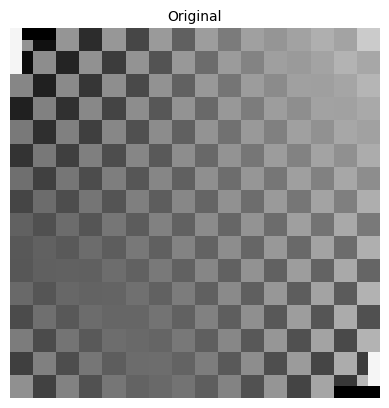

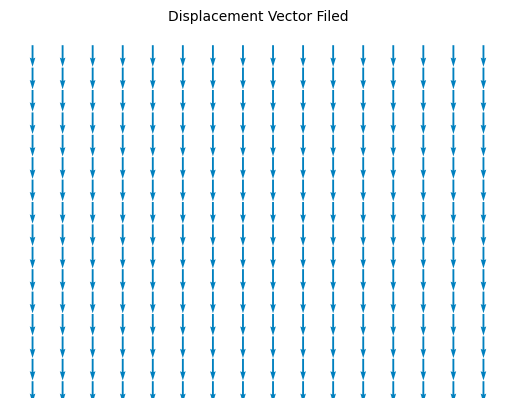

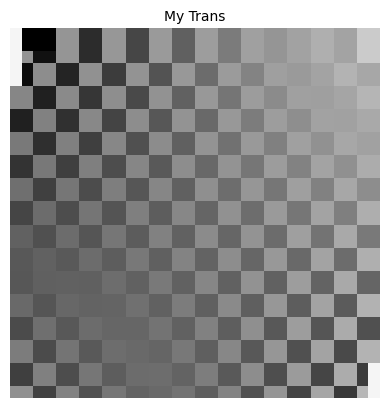

flow filed
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(64, 64), dtype=float32)
tf.Tensor(
[[-2. -2. -2. ... -2. -2. -2.]
 [-2. -2. -2. ... -2. -2. -2.]
 [-2. -2. -2. ... -2. -2. -2.]
 ...
 [-2. -2. -2. ... -2. -2. -2.]
 [-2. -2. -2. ... -2. -2. -2.]
 [-2. -2. -2. ... -2. -2. -2.]], shape=(64, 64), dtype=float32)


Sampling points
tf.Tensor(
[[ 0.  1.  2. ... 61. 62. 63.]
 [ 0.  1.  2. ... 61. 62. 63.]
 [ 0.  1.  2. ... 61. 62. 63.]
 ...
 [ 0.  1.  2. ... 61. 62. 63.]
 [ 0.  1.  2. ... 61. 62. 63.]
 [ 0.  1.  2. ... 61. 62. 63.]], shape=(64, 64), dtype=float32)
tf.Tensor(
[[-2. -2. -2. ... -2. -2. -2.]
 [-1. -1. -1. ... -1. -1. -1.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [59. 59. 59. ... 59. 59. 59.]
 [60. 60. 60. ... 60. 60. 60.]
 [61. 61. 61. ... 61. 61. 61.]], shape=(64, 64), dtype=float32)


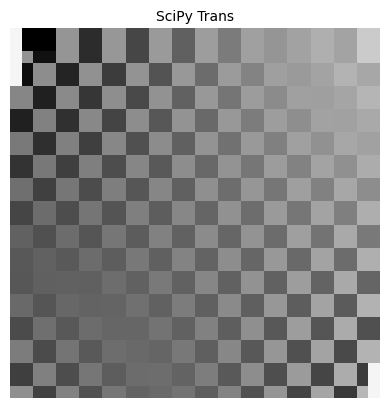

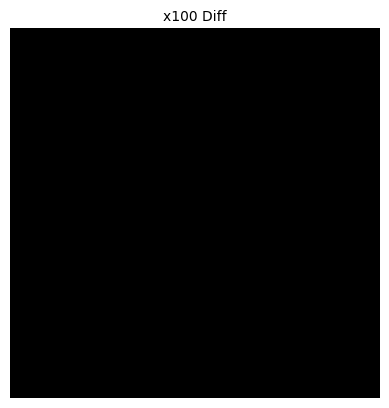

Max diff: 0.0


In [56]:
# y-direction
affine_matrix = image_affine_matrix_2d(
    image_size=(image_size_2d, image_size_2d),
    translation=(0, 2),
    scale=(1.0, 1.0),
    shear=(0.0, 0.0),
    rotation=0.0,
)

compare_results(affine_matrix, marked_img)

### Scaling

Affine matrix:
 [[ 1.1  0.  -3.2]
 [ 0.   1.   0. ]
 [ 0.   0.   1. ]]

Inverse affine matrix:
 [[0.90909091 0.         2.90909091]
 [0.         1.         0.        ]
 [0.         0.         1.        ]]


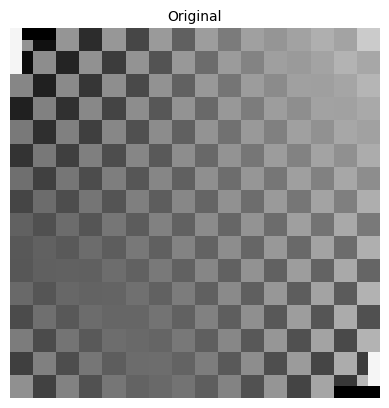

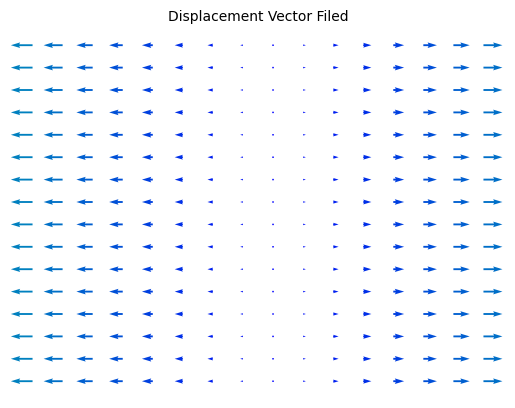

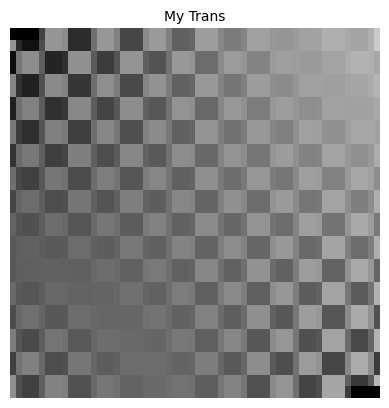

flow filed
tf.Tensor(
[[ 2.909091   2.818182   2.727273  ... -2.6363602 -2.7272682 -2.81818  ]
 [ 2.909091   2.818182   2.727273  ... -2.6363602 -2.7272682 -2.81818  ]
 [ 2.909091   2.818182   2.727273  ... -2.6363602 -2.7272682 -2.81818  ]
 ...
 [ 2.909091   2.818182   2.727273  ... -2.6363602 -2.7272682 -2.81818  ]
 [ 2.909091   2.818182   2.727273  ... -2.6363602 -2.7272682 -2.81818  ]
 [ 2.909091   2.818182   2.727273  ... -2.6363602 -2.7272682 -2.81818  ]], shape=(64, 64), dtype=float32)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(64, 64), dtype=float32)


Sampling points
tf.Tensor(
[[ 2.909091  3.818182  4.727273 ... 58.36364  59.27273  60.18182 ]
 [ 2.909091  3.818182  4.727273 ... 58.36364  59.27273  60.18182 ]
 [ 2.909091  3.818182  4.727273 ... 58.36364  59.27273  60.18182 ]
 ...
 [ 2.909091  3.818182  4.727273 ... 58.36364  59.27273  60.18182 ]
 

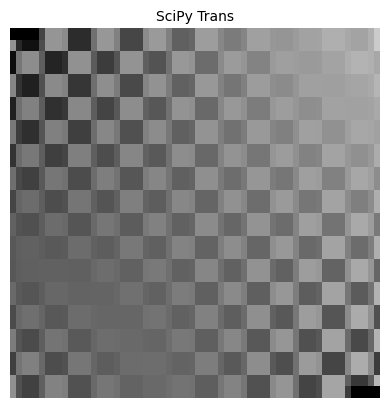

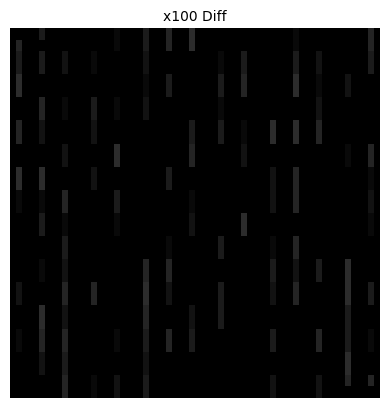

Max diff: 0.4548492431640625


In [57]:
# x-direction
affine_matrix = image_affine_matrix_2d(
    image_size=(image_size_2d, image_size_2d),
    translation=(0, 0),
    scale=(1.1, 1.0),
    shear=(0.0, 0.0),
    rotation=0.0,
)

compare_results(affine_matrix, marked_img)

Affine matrix:
 [[1.  0.  0. ]
 [0.  0.9 3.2]
 [0.  0.  1. ]]

Inverse affine matrix:
 [[ 1.          0.          0.        ]
 [ 0.          1.11111111 -3.55555556]
 [ 0.          0.          1.        ]]


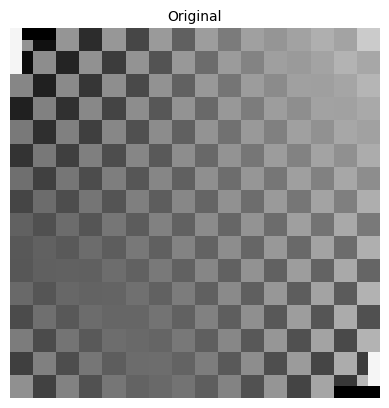

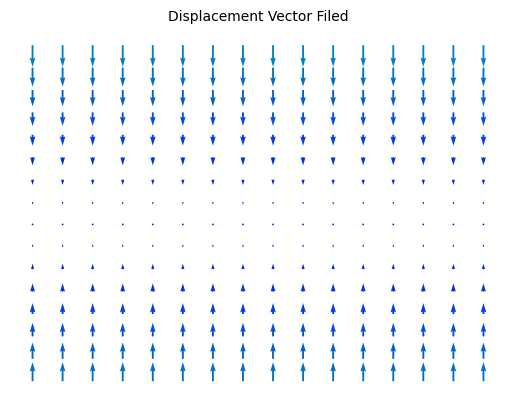

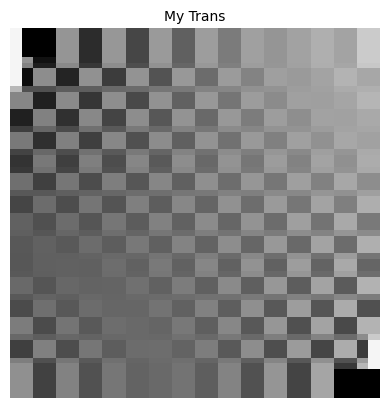

flow filed
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(64, 64), dtype=float32)
tf.Tensor(
[[-3.5555556 -3.5555556 -3.5555556 ... -3.5555556 -3.5555556 -3.5555556]
 [-3.4444444 -3.4444444 -3.4444444 ... -3.4444444 -3.4444444 -3.4444444]
 [-3.3333333 -3.3333333 -3.3333333 ... -3.3333333 -3.3333333 -3.3333333]
 ...
 [ 3.2222214  3.2222214  3.2222214 ...  3.2222214  3.2222214  3.2222214]
 [ 3.3333359  3.3333359  3.3333359 ...  3.3333359  3.3333359  3.3333359]
 [ 3.4444427  3.4444427  3.4444427 ...  3.4444427  3.4444427  3.4444427]], shape=(64, 64), dtype=float32)


Sampling points
tf.Tensor(
[[ 0.  1.  2. ... 61. 62. 63.]
 [ 0.  1.  2. ... 61. 62. 63.]
 [ 0.  1.  2. ... 61. 62. 63.]
 ...
 [ 0.  1.  2. ... 61. 62. 63.]
 [ 0.  1.  2. ... 61. 62. 63.]
 [ 0.  1.  2. ... 61. 62. 63.]], shape=(64, 64), dtype=float32)
tf.Tensor(
[[-3.5555556 -3.5555556 -3.5555556 ... 

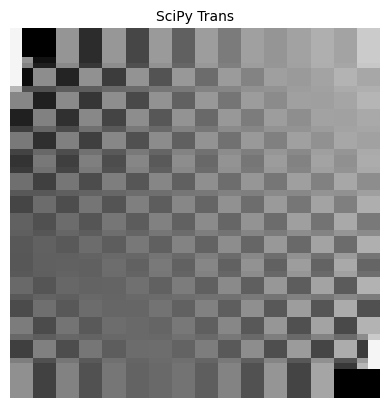

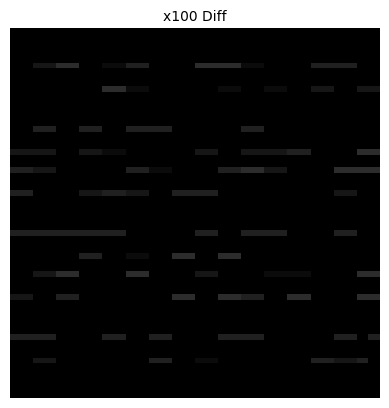

Max diff: 0.444610595703125


In [71]:
# y-direction
affine_matrix = image_affine_matrix_2d(
    image_size=(image_size_2d, image_size_2d),
    translation=(0, 0),
    scale=(1.0, 1.1),
    shear=(0.0, 0.0),
    rotation=0.0,
)

compare_results(affine_matrix, marked_img)

### Shear

Affine matrix:
 [[ 1.  -0.1  3.2]
 [ 0.   1.   0. ]
 [ 0.   0.   1. ]]

Inverse affine matrix:
 [[ 1.   0.1 -3.2]
 [ 0.   1.   0. ]
 [ 0.   0.   1. ]]


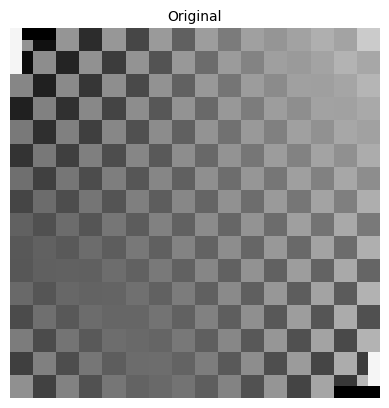

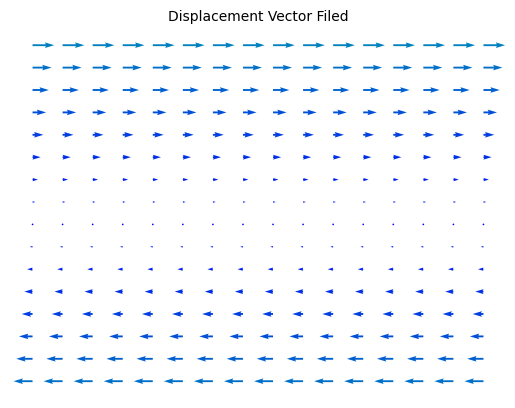

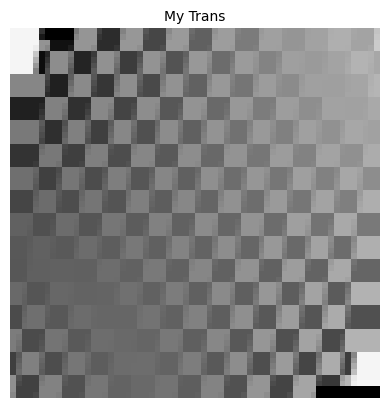

flow filed
tf.Tensor(
[[-3.2       -3.2       -3.2       ... -3.2000008 -3.2000008 -3.2000008]
 [-3.1000001 -3.1       -3.1000001 ... -3.1000023 -3.1000023 -3.1000023]
 [-3.        -3.        -3.        ... -3.        -3.        -3.       ]
 ...
 [ 2.8999999  2.8999999  2.9000006 ...  2.8999977  2.9000015  2.9000015]
 [ 3.0000002  3.         3.000001  ...  2.9999962  3.         3.       ]
 [ 3.1000001  3.1000004  3.1000004 ...  3.100006   3.100006   3.100006 ]], shape=(64, 64), dtype=float32)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(64, 64), dtype=float32)


Sampling points
tf.Tensor(
[[-3.2       -2.2       -1.2       ... 57.8       58.8       59.8      ]
 [-3.1000001 -2.1       -1.1000001 ... 57.899998  58.899998  59.899998 ]
 [-3.        -2.        -1.        ... 58.        59.        60.       ]
 ...
 [ 2.8999999  3.8999999  4.9000006 ... 63.899998  

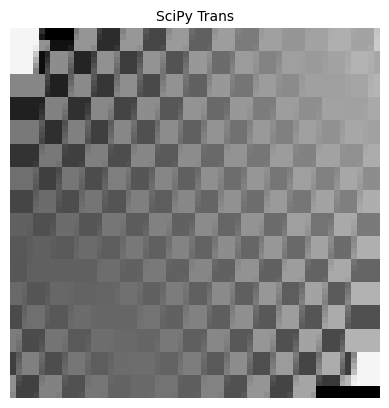

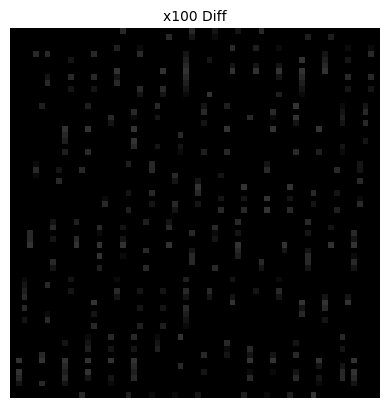

Max diff: 0.500701904296875


In [60]:
# x-direction
affine_matrix = image_affine_matrix_2d(
    image_size=(image_size_2d, image_size_2d),
    translation=(0, 0),
    scale=(1.0, 1.0),
    shear=(0.1, 0.0),
    rotation=0.0,
)

compare_results(affine_matrix, marked_img)

Affine matrix:
 [[ 1.   0.   0. ]
 [ 0.1  1.  -3.2]
 [ 0.   0.   1. ]]

Inverse affine matrix:
 [[ 1.   0.   0. ]
 [-0.1  1.   3.2]
 [ 0.   0.   1. ]]


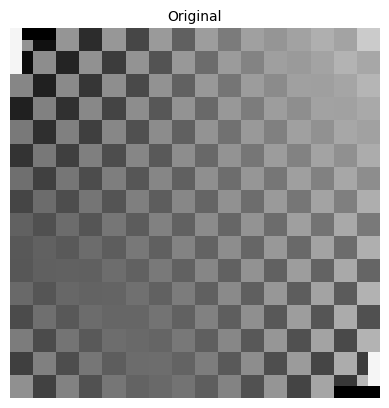

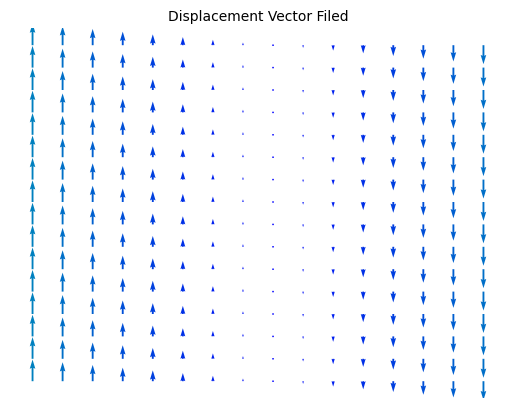

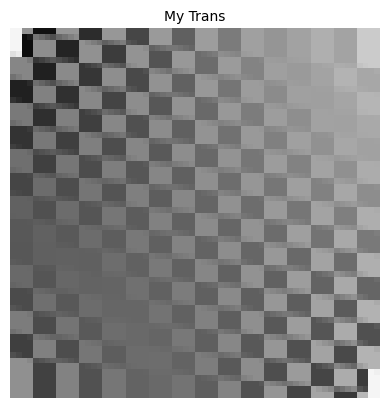

flow filed
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(64, 64), dtype=float32)
tf.Tensor(
[[ 3.2        3.1000001  3.        ... -2.8999999 -3.0000002 -3.1000001]
 [ 3.1999998  3.1        3.        ... -2.8999999 -3.0000002 -3.1000001]
 [ 3.1999998  3.1        3.        ... -2.8999999 -3.0000002 -3.1000001]
 ...
 [ 3.199997   3.0999985  3.        ... -2.8999977 -3.        -3.0999985]
 [ 3.199997   3.0999985  3.        ... -2.8999977 -3.        -3.0999985]
 [ 3.199997   3.0999985  3.        ... -2.8999977 -3.        -3.0999985]], shape=(64, 64), dtype=float32)


Sampling points
tf.Tensor(
[[ 0.  1.  2. ... 61. 62. 63.]
 [ 0.  1.  2. ... 61. 62. 63.]
 [ 0.  1.  2. ... 61. 62. 63.]
 ...
 [ 0.  1.  2. ... 61. 62. 63.]
 [ 0.  1.  2. ... 61. 62. 63.]
 [ 0.  1.  2. ... 61. 62. 63.]], shape=(64, 64), dtype=float32)
tf.Tensor(
[[ 3.2         3.1000001   3.         .

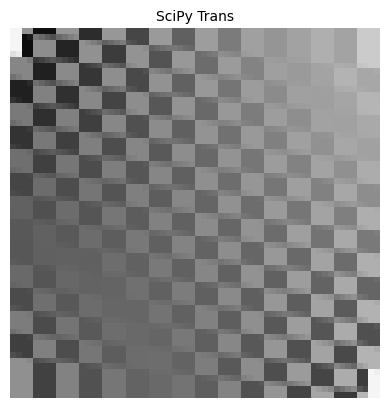

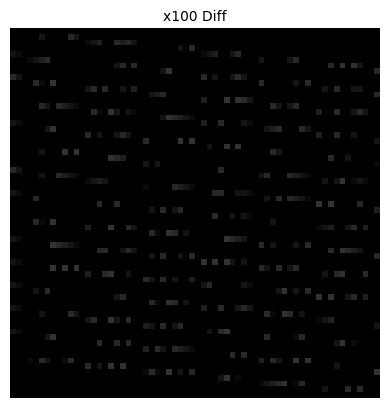

Max diff: 0.50006103515625


In [67]:
# y-direction
affine_matrix = image_affine_matrix_2d(
    image_size=(image_size_2d, image_size_2d),
    translation=(0, 0),
    scale=(1.0, 1.0),
    shear=(0.0, 0.1),
    rotation=0.0,
)

compare_results(affine_matrix, marked_img)

### Rotation

Affine matrix:
 [[ 0.99500417 -0.09983342  3.35453604]
 [ 0.09983342  0.99500417 -3.03480262]
 [ 0.          0.          1.        ]]

Inverse affine matrix:
 [[ 0.99500417  0.09983342 -3.03480262]
 [-0.09983342  0.99500417  3.35453604]
 [ 0.          0.          1.        ]]


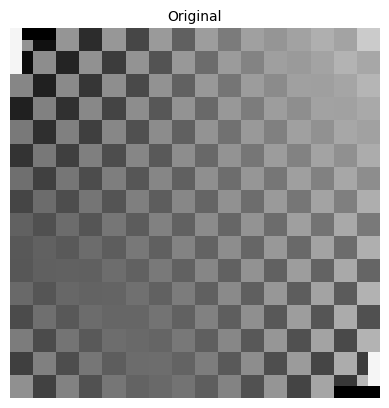

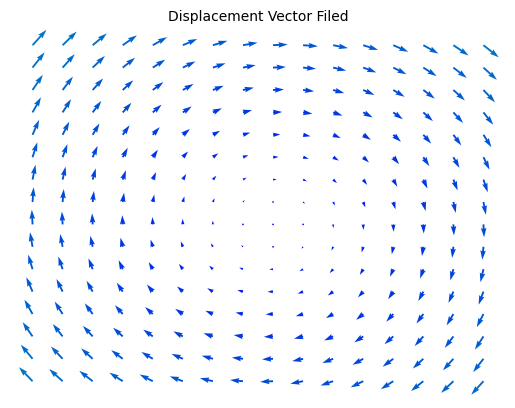

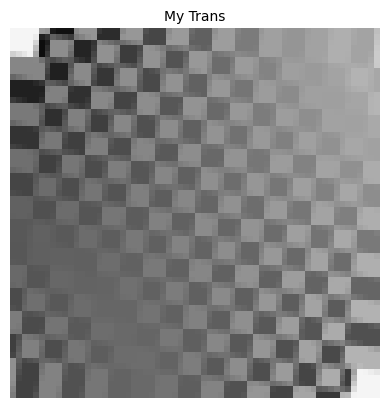

flow filed
tf.Tensor(
[[-3.0348027 -3.0397985 -3.0447943 ... -3.3395462 -3.3445435 -3.349537 ]
 [-2.9349692 -2.9399652 -2.9449608 ... -3.2397118 -3.244709  -3.2497025]
 [-2.835136  -2.8401318 -2.8451276 ... -3.1398811 -3.1448784 -3.1498718]
 ...
 [ 3.0550354  3.0500393  3.045044  ...  2.7502937  2.7452927  2.7402954]
 [ 3.1548688  3.1498728  3.1448774 ...  2.8501244  2.8451233  2.8401337]
 [ 3.2547023  3.2497063  3.244711  ...  2.949955   2.9449615  2.9399643]], shape=(64, 64), dtype=float32)
tf.Tensor(
[[ 3.354536   3.2547026  3.1548693 ... -2.735302  -2.8351355 -2.934969 ]
 [ 3.3495402  3.2497067  3.1498733 ... -2.7402978 -2.8401313 -2.9399648]
 [ 3.3445444  3.244711   3.1448774 ... -2.7452936 -2.845127  -2.9449606]
 ...
 [ 3.0497894  2.9499588  2.8501282 ... -3.0400467 -3.1398773 -3.2397156]
 [ 3.0447922  2.9449615  2.845131  ... -3.045044  -3.1448746 -3.2447128]
 [ 3.0398026  2.9399643  2.8401337 ... -3.0500336 -3.1498718 -3.2497025]], shape=(64, 64), dtype=float32)


Sampling poin

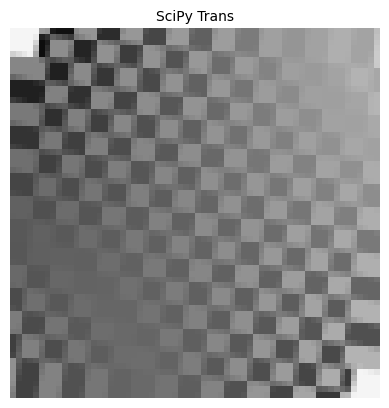

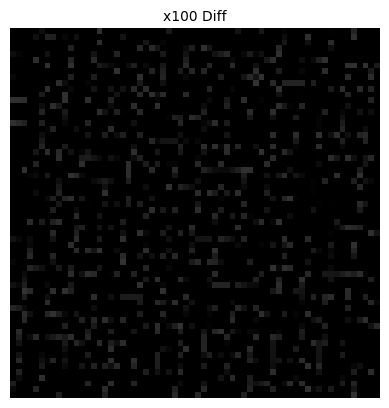

Max diff: 0.5000228881835938


In [65]:
affine_matrix = image_affine_matrix_2d(
    image_size=(image_size_2d, image_size_2d),
    translation=(0, 0),
    scale=(1.0, 1.0),
    shear=(0.0, 0.0),
    rotation=-0.1,
)

compare_results(affine_matrix, marked_img)

## 3D

### Help Functions

In [87]:
def img_slice(img, z=None):
    if z is None:
        z = np.shape(img)[2] / 2
    return img[..., int(z), :]


def tensor_slice(tensor, z=None):
    if z is None:
        z = tf.shape(tensor).numpy()[3] / 2
    return tensor[..., int(z), :]


def flow_slice(tensor, z=None):
    return tensor_slice(tensor, z)[..., 0:2]


def z_image_slider(img, title, image_size=64, cell_size=4):
    slider = widgets.FloatSlider(
        value=2,
        min=2,
        max=image_size - 1,
        step=cell_size,
        description="Image Z-Axis Slice:\n",
    )  # we jump between middles of the chessboard cubes

    interact(lambda z: plot_img(img_slice(img, z), title), z=slider)


def z_flow_slider(tensor, image_size=64):
    slider = widgets.FloatSlider(
        value=1,
        min=1,
        max=image_size - 1,
        step=1,
        description="Displacement Z-Axis Slice:\n",
    )  # we jump between middles of the chessboard cubes

    interact(lambda z: draw_displacement_field(flow_slice(tensor, z)), z=slider)

In [88]:
def apply_affine_matrix_my_3d(inv_matrix, img):
    image_core_size = list(img.shape[0:3])

    inv_trans_tensor = array_to_tensor(inv_matrix)

    flow_field = flow_fields_from_batch_affine_matrices(
        inv_trans_tensor, image_core_size, config.float_data_type
    )

    z_flow_slider(flow_field)

    img_tensor = array_to_tensor(img)
    img_output_tensor, transformation_grid = warp_images(img_tensor, flow_field)

    img_output_array = tensor_to_array(img_output_tensor)

    flow_field = flow_slice(flow_field)
    transformation_grid = tensor_slice(transformation_grid)

    z_image_slider(img_output_array, "My Trans")

    print("flow filed")
    print(flow_field[0, ..., 0])
    print(flow_field[0, ..., 1])

    print("\n========\n")

    print("Sampling points")
    print(transformation_grid[0, :, :, 0])
    print(transformation_grid[0, :, :, 1])

    return img_output_array[..., 0]

In [89]:
def apply_affine_matrix_scipy_3d(matrix, img):
    # Scipy assumes y-x coordinates in the matrix, so we need to switch from x-y.
    # but doing this for the affine matrix is not straight forward, so instead we
    # transpose the image and then apply the matrix, then transpose back

    img = np.transpose(img, (1, 0, 2, 3))

    transformed_image = affine_transform(
        input=img[:, :, :, 0], matrix=matrix, mode="nearest", order=1, prefilter=False
    )

    transformed_image = np.transpose(transformed_image, (1, 0, 2))

    z_image_slider(transformed_image[:, :, :, np.newaxis], "Scipy Trans")

    return transformed_image

In [90]:
def compare_results_3d(matrix, img):
    inv_matrix = np.linalg.inv(matrix)

    print("Affine matrix:\n", matrix)
    print("\nInverse affine matrix:\n", inv_matrix)

    z_image_slider(img, "Original")

    trans_img_my = apply_affine_matrix_my_3d(inv_matrix, img)

    trans_img_scipy = apply_affine_matrix_scipy_3d(inv_matrix, img)

    diff = trans_img_scipy - trans_img_my
    dif_max = np.max(np.abs(diff))

    if dif_max < 2.55:
        z_image_slider(
            np.clip(diff * 100, 0, 255), "x100 Diff"
        )  # we magnify differences to detect any
    else:
        z_image_slider(diff, "Diff")

    print(f"Max diff: {dif_max}")

### Generate Image

In [92]:
cell_size_3d = 4
image_size_3d = 64
rank_3d = 3

img_3d = random_gradient_chessboard(
    output_size=[image_size_3d] * rank_3d,
    random_cells_size_range=(cell_size_3d, cell_size_3d + 1),
    channels_count=1,
)

z_image_slider(img_3d, "Original")

interactive(children=(FloatSlider(value=2.0, description='Image Z-Axis Slice:\n', max=63.0, min=2.0, step=4.0)…

In [93]:
# mark corners to make it easier to spot any mirroring

marked_img_3d = img_3d.copy()

marked_img_3d[0:2, 0:32, :] = 0
marked_img_3d[0:32, 0:2, :] = 175

marked_img_3d[62:64, 32:64, :] = 245
marked_img_3d[32:64, 62:64, :] = 100

z_image_slider(marked_img_3d, "Marked")

interactive(children=(FloatSlider(value=2.0, description='Image Z-Axis Slice:\n', max=63.0, min=2.0, step=4.0)…

### Fixed Affine

In [94]:
affine_matrix_3d = image_affine_matrix_3d(
    image_size=(image_size_3d, image_size_3d, image_size_3d),
    translation=(0, 0, 0),
    scale=(1.0, 1.0, 1.0),
    shear=(0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
    rotation=(0.1, 0.0, 0.0),
)

compare_results_3d(affine_matrix_3d, marked_img_3d)

Affine matrix:
 [[ 1.          0.          0.          0.        ]
 [ 0.          0.99500417 -0.09983342  3.35453604]
 [ 0.          0.09983342  0.99500417 -3.03480262]
 [ 0.          0.          0.          1.        ]]

Inverse affine matrix:
 [[ 1.          0.          0.          0.        ]
 [ 0.          0.99500417  0.09983342 -3.03480262]
 [ 0.         -0.09983342  0.99500417  3.35453604]
 [ 0.          0.          0.          1.        ]]


interactive(children=(FloatSlider(value=2.0, description='Image Z-Axis Slice:\n', max=63.0, min=2.0, step=4.0)…

interactive(children=(FloatSlider(value=1.0, description='Displacement Z-Axis Slice:\n', max=63.0, min=1.0, st…

interactive(children=(FloatSlider(value=2.0, description='Image Z-Axis Slice:\n', max=63.0, min=2.0, step=4.0)…

flow filed
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(64, 64), dtype=float32)
tf.Tensor(
[[ 0.16015625  0.16015625  0.16015625 ...  0.16015625  0.16015625
   0.16015625]
 [ 0.15527344  0.15527344  0.15527344 ...  0.15527344  0.15527344
   0.15527344]
 [ 0.15039062  0.15039062  0.15039062 ...  0.15039062  0.15039062
   0.15039062]
 ...
 [-0.13769531 -0.13769531 -0.13769531 ... -0.13769531 -0.13769531
  -0.13769531]
 [-0.14257812 -0.14257812 -0.14257812 ... -0.14257812 -0.14257812
  -0.14257812]
 [-0.14746094 -0.14746094 -0.14746094 ... -0.14746094 -0.14746094
  -0.14746094]], shape=(64, 64), dtype=float32)


Sampling points
tf.Tensor(
[[ 0.  1.  2. ... 61. 62. 63.]
 [ 0.  1.  2. ... 61. 62. 63.]
 [ 0.  1.  2. ... 61. 62. 63.]
 ...
 [ 0.  1.  2. ... 61. 62. 63.]
 [ 0.  1.  2. ... 61. 62. 63.]
 [ 0.  1.  2. ... 61. 62. 63.]], shape=(64, 64), dtype=float32)
tf

interactive(children=(FloatSlider(value=2.0, description='Image Z-Axis Slice:\n', max=63.0, min=2.0, step=4.0)…

interactive(children=(FloatSlider(value=2.0, description='Image Z-Axis Slice:\n', max=63.0, min=2.0, step=4.0)…

Max diff: 2.239501953125


### Random Affine

In [95]:
affine_matrix_3d = random_image_affine_matrix(
    image_size=(image_size_3d, image_size_3d, image_size_3d),
    origin_shift_range=(2, 2),
    translations_range=(0, 2),
    rotations_range=(0, 0.1),
    shears_range=(0, 0.1),
    scales_ranges=((1, 1.1), (1, 1.1)),
)

compare_results_3d(affine_matrix_3d, marked_img_3d)

Affine matrix:
 [[ 1.01551724  0.0219438  -0.11473315  2.84630604]
 [-0.15845766  1.08158499  0.00416834  3.45958456]
 [ 0.0286843   0.0950462   1.05527666 -4.13020495]
 [ 0.          0.          0.          1.        ]]

Inverse affine matrix:
 [[ 0.97716393 -0.02917144  0.10635571 -2.24111565]
 [ 0.14331156  0.92061178  0.01194489 -3.54350803]
 [-0.03946878 -0.08212433  0.94365202  4.29393254]
 [ 0.          0.          0.          1.        ]]


interactive(children=(FloatSlider(value=2.0, description='Image Z-Axis Slice:\n', max=63.0, min=2.0, step=4.0)…

interactive(children=(FloatSlider(value=1.0, description='Displacement Z-Axis Slice:\n', max=63.0, min=1.0, st…

interactive(children=(FloatSlider(value=2.0, description='Image Z-Axis Slice:\n', max=63.0, min=2.0, step=4.0)…

flow filed
tf.Tensor(
[[ 1.1640625   1.1411133   1.1181641  ... -0.23583984 -0.25878906
  -0.28173828]
 [ 1.1348877   1.1119385   1.0889893  ... -0.26501465 -0.28796387
  -0.3109131 ]
 [ 1.1057129   1.0827637   1.0598145  ... -0.29418945 -0.31713867
  -0.3400879 ]
 ...
 [-0.6156006  -0.6385498  -0.661499   ... -2.015503   -2.0384521
  -2.0614014 ]
 [-0.6447754  -0.6677246  -0.6906738  ... -2.0446777  -2.067627
  -2.0905762 ]
 [-0.6739502  -0.6968994  -0.71984863 ... -2.0738525  -2.0968018
  -2.119751  ]], shape=(64, 64), dtype=float32)
tf.Tensor(
[[-3.1606445  -3.017334   -2.8740234  ...  5.581299    5.7246094
   5.86792   ]
 [-3.2402344  -3.0969238  -2.9536133  ...  5.501709    5.6450195
   5.78833   ]
 [-3.3198242  -3.1765137  -3.0332031  ...  5.422119    5.5654297
   5.70874   ]
 ...
 [-8.015625   -7.8723145  -7.729004   ...  0.72631836  0.8696289
   1.0129395 ]
 [-8.095215   -7.9519043  -7.8085938  ...  0.6467285   0.79003906
   0.9333496 ]
 [-8.174805   -8.031494   -7.8881836  ...

interactive(children=(FloatSlider(value=2.0, description='Image Z-Axis Slice:\n', max=63.0, min=2.0, step=4.0)…

interactive(children=(FloatSlider(value=2.0, description='Image Z-Axis Slice:\n', max=63.0, min=2.0, step=4.0)…

Max diff: 3.02056884765625
